# 量化子消去のアルゴリズム(具体的な命題文の場合)

具体的に次の命題文について，量化子消去を行う．

$\forall x (x^2 + a^2 < 1 \land a < x)$

この命題文は, $-1<a<1/\sqrt{2}$に同値である．

この命題文に登場する多項式は$x^2 + a^2 - 1, a-x$のみである．

In [30]:
R.<x,a> = QQ[]

# # ここにCADしたい多項式のリストを渡す
F = [x^2 + a^2-1,a-x];F

[x^2 + a^2 - 1, -x + a]

量化子消去を行うためにCADを求める．まず，射影$G= \mathrm{PROJ}(F)$をを求める．

In [31]:
# 主部分終結式係数全体(principal subresultant coefficient)
# 一つ一つ出力するほうがわかりやすいが, sagemathはsubresultantsモジュールしか備えておらず, そのためすべてを出力するように実装する.
def PSCs(f, g):
    """
    deg(f)>= 0, deg(g)>= 0, つまり, f != 0, g!= 0を仮定する.
    """
    if f == 0 or g == 0:
        return False
    psc_list = []
    subres = f.subresultants(g)
    for i in range(len(subres)):
        if subres[i].degree()==i:
            psc_list.append(subres[i].lc())
        else:
            psc_list.append(0)
    
    return psc_list

In [32]:
def PROJ(F):
    R = F[0].parent()
    F = [R(f).polynomial(R.gen()) for f in F]
    
    # FのReductionをすべて計算し, その集合をBとする
    B = []
    for f in F:
        A = f
        while(A != 0):
            B.append(A)
            A = A - A.lt()
            
    # Bの先頭項係数全体をLとする.
    L = {b.lc() for b in B}

    # PSC_k(b, b')全体をS1とする.
    S1 = []
    for b in B:
        if b.degree()>0:
            S1 = S1 + PSCs(b, b.diff())            
    S1 = set(S1)
    
    # PSC_k(b_1, b_2)全体をS2とする.
    S2 = []
    for i in range(len(B)):
        for j in range(i+1,len(B)):
            S2 = S2 + PSCs(B[i],B[j])
    S2 = set(S2)
    
    proj = {f for f in L | S1 | S2 if not f in RR}
    return list(proj)

In [33]:
G = PROJ(F);G

[4*a^2 - 4, a^2 - 1, 2*a^2 - 1, a]

$G$不変な$\mathbb{R}$の分割を求める．

In [34]:
def base(F):
    # 前処理: 定数となるようなFは除く.
    F = [f for f in F if f not in AA]
    
    B = []
    for g in F:
        B += g.roots(AA, multiplicities = False)
    B = list(set(B))
    B.sort()
    
    ans = []
    if(len(B) == 0):
        ans.append(AA(0))
    else:
        ans.append(B[0]-1)
        for i in range(len(B)-1):
            ans.append(B[i])
            ans.append((B[i]+B[i+1])/2)
        ans.append(B[-1])
        ans.append(B[-1]+1)
    
    ans = [(a,) for a in ans]
    return ans


In [35]:
base(G)

[(-2,),
 (-1,),
 (-0.8535533905932738?,),
 (-0.7071067811865475?,),
 (-0.3535533905932738?,),
 (0,),
 (0.3535533905932738?,),
 (0.7071067811865475?,),
 (0.8535533905932738?,),
 (1,),
 (2,)]

ここで求めた$\mathbb{R}$の分割の各セルの定義式が問題となる．
ここで，$G$の生成する微分で閉じた集合$AG$とすると, これは各セルを分離する定義式である．

In [36]:
f = x^2 + a^2
f = R(f).polynomial(a)
f.diff()

2*a

In [37]:
def Augment(F):
    R = F[0].parent()
    F = [R(f).polynomial(R.gen()) for f in F]
    
    AF = []
    for f in F:
        while(f != 0):
            AF.append(f)
            f = f.diff()
    
    AF = set(AF)
    return AF

In [38]:
AG = Augment(G);AG

{1, 2, 4, 8, a, 2*a, 4*a, 8*a, a^2 - 1, 2*a^2 - 1, 4*a^2 - 4}

この集合$AG$は, 上で求めた$\mathbb{R}$の定義式となる．

In [39]:
def lifting(Base, F):
    R = F[0].parent()
    ans = []
    for b in Base:
        F_1 = [AA[f"{R.gen()}"](f((R.gen(),)+b)) for f in F]
        for a in base(F_1):
            ans.append(a+b)
    return ans

持ち上げを計算し, どのセルが条件式を満たしているかをチェックする．
条件を満たすセルの代表点をすべて表示する．

In [40]:
G = PROJ(F)
Base = base(G)
print(Base)
Samples = lifting(Base,F)

[(-2,), (-1,), (-0.8535533905932738?,), (-0.7071067811865475?,), (-0.3535533905932738?,), (0,), (0.3535533905932738?,), (0.7071067811865475?,), (0.8535533905932738?,), (1,), (2,)]


In [41]:
# 条件を満たしているサンプルポイントのリスト:
Satisfies = []
for (b1,) in Base:
    for (a,b2) in Samples:
        if b1 == b2:
            if F[0](a,b2)<0 and F[1](a,b2)<0:
                Satisfies.append((b1,))
                break
Satisfies

[(-0.8535533905932738?,),
 (-0.7071067811865475?,),
 (-0.3535533905932738?,),
 (0,),
 (0.3535533905932738?,)]

最後に，代数的命題文で記述する．簡単のため，AGは先頭項係数を0にしておく.

In [42]:
AG = {g/g.lc() for g in AG};AG

{1, a, a^2 - 1, a^2 - 1/2}

In [43]:
sentences = []
for (b,) in Satisfies:
        lst = []
        for g in AG:
            if g(b) > 0:
                lst += [f"{g} > 0"]
            elif g(b) == 0:
                lst += [f"{g} = 0"]
            elif g(b) < 0:
                lst += [f"{g} < 0"]
        sentences.append("(" + " and ".join(lst) + ")")

sentences       

['(a^2 - 1/2 > 0 and 1 > 0 and a^2 - 1 < 0 and a < 0)',
 '(a^2 - 1/2 = 0 and 1 > 0 and a^2 - 1 < 0 and a < 0)',
 '(a^2 - 1/2 < 0 and 1 > 0 and a^2 - 1 < 0 and a < 0)',
 '(a^2 - 1/2 < 0 and 1 > 0 and a^2 - 1 < 0 and a = 0)',
 '(a^2 - 1/2 < 0 and 1 > 0 and a^2 - 1 < 0 and a > 0)']

これらをorでつなげば, (一応)量化子消去が終了したことになる.たしかにこれは$-1 < a < 1/\sqrt{2}$ではあるけども...．

# 東京大学文科2021年数学 大問3 (1)

量化記号消去したい論理式は

$\phi(a,b) = \exists x_1 \exists x_2 (-1 < x_1 < 0 \land 0 < x_2 < 1 \land x_1^2+ax_1+b = -x_1^2 \land x_2^2 + ax_2 + b = -x_2^2)$

である．
この命題文は，

$\theta(a,b) = b < 0 \land a+b+2>0 \land b-a+2>0$

に同値であることが分かっている．

さて，この問題の量化記号消去を行うために，

$F = \{x_1, x_2,2x_1^2+ax_1 +b, 2x_2^2+ax_2+b\}$

とし，$F$適合な$\mathbb{R}^4$の柱状代数分解を構成しよう．

In [250]:
R.<x1, x2, a, b> = QQ[]

F = [x1,x1+1, x2, x2-1, 2*x1^2 + a*x1+ b, 2*x2^2+a*x2+b];F

[x1, x1 + 1, x2, x2 - 1, 2*x1^2 + x1*a + b, 2*x2^2 + x2*a + b]

## DERの定義

In [252]:
def DER(F):
    x = F[0].parent().gen()
    F = {f.polynomial(x) for f in F}
    
    der = []
    for f in F:
        while(f != 0):
            der.append(f)
            f=f.diff()
    return list(set(der))

## PROJの定義

In [253]:
def PROJ(F):
    x = F[0].parent().gen()
    F = [f.polynomial(x) for f in F]
    
    # Fのreductionをすべて計算し，その集合をBとする．
    B = []
    for f in F:
        while(f != 0):
            B.append(f)
            f = f - f.lt()
    
    # Bの先頭項係数全体をLとする．
    L = {b.lc() for b in B}
    
    # PSC(b, b')全体をS1とする．
    S1 = []
    for f in B:
        if (f.degree() == 0):
            continue
        s = f.subresultants(f.diff())
        for i in range(len(s)):
            if (s[i].degree()==i):
                S1.append(s[i].lc())
    S1 = set(S1)
            
    # PSC(b1, b2)全体をS2とする．
    S2 = []
    for i in range(len(B)):
        if (B[i].degree() == 0):
            continue
        for j in range(i+1, len(B)):
            if(B[j].degree()==0):
                continue
            s = B[i].subresultants(B[j])
            for k in range(len(s)):
                if (s[k].degree()==k):
                    S2.append(s[k].lc())
    S2 = set(S2)
    
    proj = (S1 | S2 | L)-{0}
    return list(set(proj))

## ImprovedCADの定義

In [255]:
def ImprovedCAD(F):
    Fbar = [DER(F)]
    for i in range(len(R.gens())-1):
        Fbar.append(DER(PROJ(Fbar[-1])))
    return Fbar

## BASEの定義

In [281]:
def BASE(F, b):
    R = F[0].parent()
    F = [AA[f"{R.gen()}"](f(b+[R.gen()])) for f in F]

    # 前処理：定数となるようなFは除く．
    F = [f for f in F if f.degree() != 0]
    
    B=[]
    for g in F:
        B += g.roots(AA, multiplicities = False)
    B = list(set(B))
    B.sort()
    
    ans = []
    if(len(B)==0):
        ans.append(AA(0))
    else:
        ans.append(B[0]-1)
        for i in range(len(B)-1):
            ans.append(B[i])
            ans.append((B[i]+B[i+1])/2)
        ans.append(B[-1])
        ans.append(B[-1]+1)
    
    ans = [b + [a,] for a in ans]
    return ans

## DECOMPの定義

In [282]:
F4,F3,F2,F1 = ImprovedCAD(F)

In [284]:
base = BASE(F1,[])
base[0]

[-7]

In [285]:
BASE(F2,base[0])

[[-7, -10],
 [-7, -9],
 [-7, -8],
 [-7, -7],
 [-7, -3.5000000000000000?],
 [-7, 0],
 [-7, 2.5000000000000000?],
 [-7, 5],
 [-7, 5.5625000000000000?],
 [-7, 6.1250000000000000?],
 [-7, 6.5625000000000000?],
 [-7, 7],
 [-7, 9.6250000000000000?],
 [-7, 12.250000000000000?],
 [-7, 13.250000000000000?]]

In [280]:
base = BASE(F1,[])

b = base[0]

beta = [b,[]]
beta[1] = BASE(F2, beta[0])
beta

[[-7],
 [[-10],
  [-9],
  [-8],
  [-7],
  [-3.5000000000000000?],
  [0],
  [2.5000000000000000?],
  [5],
  [5.5625000000000000?],
  [6.1250000000000000?],
  [6.5625000000000000?],
  [7],
  [9.6250000000000000?],
  [12.250000000000000?],
  [13.250000000000000?]]]

In [227]:
def DECOMP(Flist, b):
    beta = (b,[])
    for F in Flist:
        beta[1] = BASE(F, beta[0])
    return beta

In [137]:
R.<x1, x2, a, b> = QQ[]

F = [x1,x1+1, x2, x2-1, 2*x1^2 + a*x1+ b, 2*x2^2+a*x2+b];F

[x1, x1 + 1, x2, x2 - 1, 2*x1^2 + x1*a + b, 2*x2^2 + x2*a + b]

In [180]:
F4,F3,F2,F1 = ImprovedCAD(F)

## CADの描画

定数倍などを消去する．

In [211]:
Fbar1 = []
for f in F1:
    for h,_ in  f.factor():
        if h.degree()!=0:
            Fbar1.append(h)
Fbar1 = set(Fbar1)

Fbar1

{b - 8, b - 4, b - 2, b, b + 1, b + 2, b + 4, b + 6, b^2 + 4}

In [208]:
Fbar2 = []
for f in F2:
    for h,_ in f.factor():
        if h not in QQ:
            Fbar2.append(h)
Fbar2 = set(Fbar2)

Fbar2

{-a + b, a - 4, a, a + 4, a - b - 2, a + b, a + b + 2, a^2 - 8*b, a^2 - 4*b}

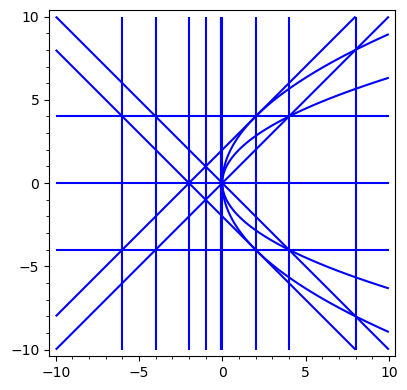

In [209]:
G = Graphics()
for f in Fbar1:
    G += implicit_plot(f,(b,-10,10),(a,-10,10))

for g in Fbar2:
    G += implicit_plot(g, (b,-10,10), (a,-10,10))
G

かなり複雑な条件となってしまっている．

In [225]:
lst = [1,[]]
lst[1]+= [1,2,3,4,5]

In [226]:
lst[1]

[1, 2, 3, 4, 5]

In [220]:
lst =[1,2,3,4,5]
lst.reverse()
lst

[5, 4, 3, 2, 1]